## Load Packages and Data

In [1]:
import numpy as np
import scipy.optimize as opt
import scipy.stats as sts
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import scipy.integrate as intgr
plt.style.use("ggplot")
%matplotlib inline

In [2]:
incomes = np.loadtxt('incomes.txt')
sick = pd.read_csv("sick.txt")
inc_sim = np.linspace(0.01, 150000, 200)

sigma_init = 0.5
mu_init = 11

In [3]:
def log_norm_pdf(xvals, mu, sigma, cutoff):## log normal dist w/ truncated
    if cutoff == 'None':
        prob_notcut = 1.0
    else:
        prob_notcut = (sts.norm.cdf(cutoff, loc=mu, scale=sigma) -
                       sts.norm.cdf(0, loc=mu, scale=sigma))
            
    log_pdf_vals = (((1/(xvals * sigma * np.sqrt(2 * np.pi))) *
                    np.exp( - ((np.log(xvals)) - mu)**2 / (2 * sigma**2))) / 
                    prob_notcut)
    return log_pdf_vals 

def log_lik_norm(xvals, mu, sigma, cutoff): ## log liklihood
    pdf_vals = log_norm_pdf(xvals, mu, sigma, cutoff) 
    ln_pdf_vals = np.log(pdf_vals) 
    log_lik_val = ln_pdf_vals.sum() 
   
    return log_lik_val 


def log(x,mu,sigma):  ##log norm pdf w/o truncated
    temp = -pow((np.log(x)-mu),2)/2/pow(sigma,2)
    y = 1/(x*sigma*np.sqrt(2*np.pi)) * np.exp(temp)
    return y

def loglike(params,*args): ## criterion function. neg of logliklihood
    
    mu, sigma = params
    x = args
    neg_log = -np.sum((np.log(log(incomes, mu, sigma))))
    return neg_log

mu_init = 11
sig_init = 0.5
params_init = [mu_init,sig_init]
results = opt.minimize(loglike, params_init, args = incomes, method='L-BFGS-B',bounds=((0.1, None),(0.1, None)))
mu_MLE, sig_MLE = results.x
                      

### a) Make a histogram

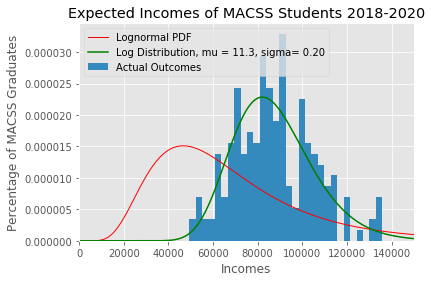

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(incomes, bins = 30, normed = True)
count, bins, ignored = plt.hist(incomes, bins = 30, normed = True, label = 'Actual Outcomes')
plt.title("Expected Incomes of MACSS Students 2018-2020")
plt.xlabel("Incomes")
plt.ylabel("Percentage of MACSS Graduates")
plt.xlim([0, 150000])

income_lognorm = log_norm_pdf(xvals = inc_sim, mu = mu_init, sigma = sigma_init, cutoff = 150000)
plt.plot(inc_sim, income_lognorm, linewidth = 1, color = 'r', label = "Lognormal PDF")

plt.plot(inc_sim, log(inc_sim, mu_MLE, sig_MLE), color = 'g', label = "Log Distribution, mu = 11.3, sigma= 0.20")

plt.legend(loc = 'upper left')

### b) Plot the lognormal PDF

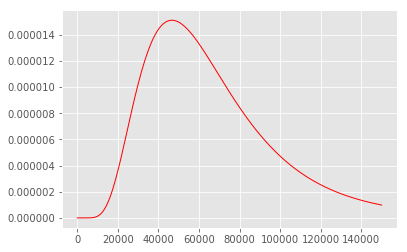

In [5]:
income_lognorm = log_norm_pdf(xvals = inc_sim, mu = mu_init, sigma = sigma_init, cutoff = 150000)
plt.plot(inc_sim, income_lognorm, linewidth = 1, color = 'r')

In [6]:
loglikeval = log_lik_norm(incomes, mu = mu_init, sigma = sigma_init, cutoff= 'None')

print('The log liklihood value is', loglikeval)

The log liklihood value is -2385.85699781


### c) Estimate the parameters of the lognormal distribution by maximum likelihood

##### Estimate Parameters

In [7]:
mu_init = 11
sig_init = 0.5
params_init = [mu_init,sig_init]
results = opt.minimize(loglike, params_init, args = incomes, method='L-BFGS-B',bounds=((0.1, None),(0.1, None)))
mu_MLE, sig_MLE = results.x
print('mu_MLE=', mu_MLE, ' sig_MLE=', sig_MLE)
results

mu_MLE= 11.3590243967  sig_MLE= 0.208178530156


      fun: 2241.7193013685201
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00645741,  0.01114131])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 48
      nit: 10
   status: 0
  success: True
        x: array([ 11.3590244 ,   0.20817853])

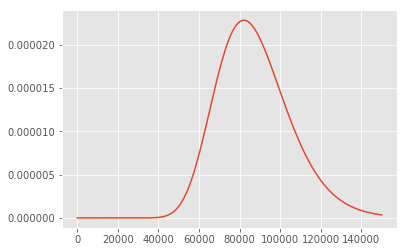

In [8]:
plt.plot(inc_sim, log(inc_sim, mu_MLE, sig_MLE))

##### VCV 

In [9]:
OffDiagNeg = np.array([[1, -1], [-1, 1]])
vcv_mle = results.hess_inv.todense() * OffDiagNeg
vcv_mle

stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print('VCV(MLE) = ', vcv_mle)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)

VCV(MLE) =  [[  2.52831353e-04  -2.76208826e-05]
 [ -2.76208826e-05   1.30457089e-04]]
Standard error for mu estimate =  0.0159006714777
Standard error for sigma estimate =  0.0114217813365


##### Value of Liklihood Function

In [10]:
loglikeval = loglike(params_init,inc_sim)
print("The Value of Liklihood Function is:", - loglikeval)

The Value of Liklihood Function is: -2385.85699781


### d) Likelihood Ratio Test

In [11]:
log_lik_h0 = log_lik_norm(incomes,mu_init,sigma_init,150000)
log_lik_mle = log_lik_norm(incomes,mu_MLE, sig_MLE,150000)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = {:.4f} '.format(pval_h0))
print('reject the null hypothesis that data comes from the original model')

chi squared of H0 with 2 degrees of freedom p-value = 0.0000 
reject the null hypothesis that data comes from the original model


### e) Proability of Earning More Than 100k. Probability of Earning Less Than 75k

In [12]:
lessthan75 = sts.lognorm.cdf(75000, s=sig_MLE, loc=mu_MLE, scale=np.exp(mu_MLE))

print('The probability of earning less than 75k is {:.4f}'.format(lessthan75))


The probability of earning less than 75k is 0.2600


In [13]:
morethan100 = 1 - sts.lognorm.cdf(100000, s=sig_MLE, loc=mu_MLE, scale=np.exp(mu_MLE))

print('The probability of earning more than 100k is {:.5f}'.format(morethan100))

The probability of earning more than 100k is 0.23004


# Question 2 - Linear Regression and MLE

### a) Estimate the parameters by maximum liklihood

In [14]:
def norm_pdf(xvals, sigma):
    pdf_vals = (1/(sigma * np.sqrt(2 * np.pi)) *
                    np.exp(-(xvals)**2 / (2 * sigma**2))) # PDF function of standard normal distribution with mu = 0 and sigma
    ln_pdf_vals = np.log(pdf_vals) # take log 
    log_lik_val = ln_pdf_vals.sum() # sum the logs
    
    return log_lik_val  # returns values of log likelihood function

In [15]:
def crit(params,*args):
    b0, b1, b2, b3, var = params
    err = sick.sick - b0 - b1*sick.age - b2*sick.children - b3*sick.avgtemp_winter
    neg_log = - np.sum(np.log(sts.norm.pdf(err,0,np.sqrt(var))))
    return(neg_log)



bd = ((None, None),(None, None), (None, None), (None, None), (0.001, None))
results2 = opt.minimize(crit, [1,0,0,0,1], bounds=bd, method='SLSQP')

print("My parameter estimates are:", results2.x)
print("My logliklihood estimate is: ", results2.fun)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


My parameter estimates are: [ 0.25164545  0.01293337  0.40050191 -0.00999164  0.001     ]
My logliklihood estimate is:  -506.077176157


##### VCV

In [16]:
results3 = opt.minimize(crit, results2.x, bounds=bd, method='L-BFGS-B')
hessian = results3.hess_inv.todense()
OffDiagNeg = np.eye(5)*2-1
vcv_mle1 = results3.hess_inv.todense() * OffDiagNeg
stderr_mu_mle = np.sqrt(vcv_mle1[0,0])
stderr_sig_mle = np.sqrt(vcv_mle1[1,1])
print('VCV(MLE) = ', vcv_mle1)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)

VCV(MLE) =  [[ 1. -0. -0. -0. -0.]
 [-0.  1. -0. -0. -0.]
 [-0. -0.  1. -0. -0.]
 [-0. -0. -0.  1. -0.]
 [-0. -0. -0. -0.  1.]]
Standard error for mu estimate =  1.0
Standard error for sigma estimate =  1.0


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


### b) Determine the Value of the Log Liklihood

In [17]:
newparams = [1, 0 , 0 ,0, .01]
log_lik_h0 = -crit(newparams)

LR_val2 = 2 * (results2.fun - log_lik_h0)
pval_LR_2 = 1.0 - sts.chi2.cdf(LR_val2, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = {:.5f}'.format(pval_LR_2))

chi squared of H0 with 2 degrees of freedom p-value = 0.00000


##### Hence, we reject the null hypothesis that age, number of children, and average winter temperature does not have effect on the number of sick days